In [35]:
import pandas as pd
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from networkx.algorithms.community import modularity_max
from tabulate import tabulate
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
import csv
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from itertools import product
from sklearn.metrics.pairwise import euclidean_distances


In [3]:
!pip install xlsxwriter
!pip install geopandas
!pip install contextily

In [4]:
!pip install Cartopy
!pip install shapely matplotlib


In [62]:
df = pd.read_csv('Psittaciformes.csv')

In [63]:
basic_columns_list = [
    'scientificName',
    'familyName',
    'orderName',

    'Beak.Length_Culmen',
    'Beak.Length_Nares',
    'Beak.Width',
    'Beak.Depth',
    'Tarsus.Length',
    'Wing.Length',
    'Kipps.Distance',
    'Hand-Wing.Index',
    'Tail.Length',
    'Mass',

    'Habitat', 
    'Habitat.Density',
    'Migration',
    'Trophic.Level', 
    'Trophic.Niche', 
    'Primary.Lifestyle',
    
    'Min.Latitude',
    'Max.Latitude',
    'Centroid.Latitude',
    'Centroid.Longitude',
    'Range.Size',


    'redlistCategory',
    'populationTrend',

]

df = df[basic_columns_list]

In [64]:
Ecological_features = [ 
    'Habitat', 
    'Trophic.Level', 
    'Trophic.Niche', 
    'Primary.Lifestyle',
    'Habitat.Density',
    'Migration',
]

# Function Definition

In [159]:
# Function to encode ecological features
def encoded_Ecological_features(df):
    categorical_columns = ['Habitat', 'Trophic.Level', 'Trophic.Niche', 'Primary.Lifestyle']
    
    # Apply one-hot encoding
    encoded_data = pd.get_dummies(df[categorical_columns], prefix=categorical_columns)

    # Add Habitat.Density and Migration (numerical column) to the encoded data
    encoded_data['Habitat.Density'] = df['Habitat.Density']
    encoded_data['Migration'] = df['Migration']
    
    # Add species_names to the encoded data
    encoded_data['species_names'] = df['scientificName'].values
    
    return encoded_data

In [158]:
def calculate_similarity_matrix(encoded_data, weights):
    # Ecological features (grouped by categories)
    ecological_feature_groups = {
        'Habitat': ['Habitat_Desert', 'Habitat_Forest', 'Habitat_Grassland', 'Habitat_Human Modified', 'Habitat_Shrubland', 'Habitat_Woodland'],
        'Trophic.Level': ['Trophic.Level_Herbivore', 'Trophic.Level_Omnivore'],
        'Trophic.Niche': ['Trophic.Niche_Frugivore', 'Trophic.Niche_Granivore', 'Trophic.Niche_Herbivore terrestrial', 'Trophic.Niche_Nectarivore', 'Trophic.Niche_Omnivore'],
        'Primary.Lifestyle': ['Primary.Lifestyle_Generalist', 'Primary.Lifestyle_Insessorial', 'Primary.Lifestyle_Terrestrial'],
        'Habitat.Density': ['Habitat.Density'],
        'Migration': ['Migration']
    }
    
    # Initialize weighted_data as an empty list (to collect each group's weighted data)
    weighted_data_list = []

    # Apply weights for each group
    feature_idx = 0  # To track column index when adding the weighted data
    for group, columns in ecological_feature_groups.items():
        # Apply weight to each feature in this group
        weight = weights[feature_idx]
        group_data = encoded_data[columns].values
        weighted_group_data = group_data * weight
        
        # Append the weighted group data to the list
        weighted_data_list.append(weighted_group_data)
        
        feature_idx += 1

    # Convert the list of weighted group data into a single 2D array
    weighted_data = np.hstack(weighted_data_list)

    # Apply weights for numeric columns
    numeric_columns = ['Habitat.Density', 'Migration']
    for feature, weight in zip(numeric_columns, weights[feature_idx:]):
        numeric_data = encoded_data[feature].values.reshape(-1, 1)  # Reshape to column vector
        weighted_data = np.hstack([weighted_data, numeric_data * weight])

    # Now, calculate the similarity matrix
    distances = euclidean_distances(weighted_data)
    similarity_matrix = np.exp(-distances)  # Convert distances to similarities (exponential scaling)

    # Get species names
    species_names = encoded_data['species_names'].values
    
    return similarity_matrix, species_names


In [165]:
# Visualize similarity distribution
def plot_similarity_distribution(similarity_matrix):
    """
    Plot the distribution of similarity values to help with thresholding
    """
    plt.figure(figsize=(10, 6))
    # Get upper triangle values
    upper_tri = similarity_matrix[np.triu_indices(len(similarity_matrix), k=1)]

    plt.hist(upper_tri, bins=50)
    plt.title('Distribution of Similarity Values')
    plt.xlabel('Similarity')
    plt.ylabel('count')


In [152]:
def create_knn_and_compute_modularity(similarity_matrix, species_names, df, k=5):
    """
    Create a KNN network and compute modularity in one function.
    
    Parameters:
        similarity_matrix: Matrix of pairwise species similarities
        species_names: List of species names
        df: DataFrame containing species attributes (latitude, longitude, family, etc.)
        k: Number of nearest neighbors to connect for each node
        
    Returns:
        G_knn: The generated KNN network
        modularity: The modularity score of the network
    """
    G_knn = nx.Graph()

    # Add nodes with attributes
    for species in species_names:
        # Get species data from DataFrame
        species_data_df = df[df['scientificName'] == species]
        
        if species_data_df.empty:
            print(f"Species {species} not found in the DataFrame. Skipping...")
            continue  # Skip this species if not found
        
        species_data = species_data_df.iloc[0]

        # Add node with relevant attributes
        G_knn.add_node(
            species,
            latitude=species_data['Centroid.Latitude'],
            longitude=species_data['Centroid.Longitude'],
            habitat=species_data['Habitat'],
            migration=species_data['Migration'],
            trophic_level=species_data['Trophic.Level'],
            trophic_niche=species_data['Trophic.Niche'],
            primary_lifestyle=species_data['Primary.Lifestyle'],
            family=species_data['familyName'],
            scientific_name=species
        )

    # Create a mask for the diagonal to exclude self-connections
    np.fill_diagonal(similarity_matrix, -np.inf)  # Set diagonal to negative infinity

    # Add edges based on k-nearest neighbors
    for i in range(len(species_names)):
        similarities = similarity_matrix[i]
        most_similar_indices = np.argsort(similarities)[::-1][:k]

        # Add edges to k nearest neighbors
        for j in most_similar_indices:
            G_knn.add_edge(
                species_names[i],
                species_names[j],
                weight=similarity_matrix[i][j]
            )

    # Compute modularity using community detection
    communities = list(nx.algorithms.community.greedy_modularity_communities(G_knn, weight='weight'))
    modularity = nx.algorithms.community.modularity(G_knn, communities, weight='weight')
    
    # Additional network statistics
    print(f"\nNetwork Statistics:")
    print(f"Number of nodes: {G_knn.number_of_nodes()}")
    print(f"Number of edges: {G_knn.number_of_edges()}")
    print(f"Average degree: {sum(dict(G_knn.degree()).values()) / G_knn.number_of_nodes():.2f}")
    print(f"Network density: {nx.density(G_knn):.4f}")
    
    return G_knn, modularity

In [173]:
def optimize_weights(df, weight_ranges, k=5, random_weights=None):
    """
    Optimize weights to maximize modularity.
    
    Parameters:
        - df: The dataframe containing species data.
        - weight_ranges: A list or range of possible weights for each feature.
        - k: Number of neighbors in the KNN graph.
        - random_weights: If provided, it overrides weight_ranges and uses these random weights instead.
        
    Returns:
        - best_weights: The best weights array found.
        - best_modularity: The highest modularity value achieved.
    """
    # Generate encoded data
    encoded_data = encoded_Ecological_features(df)  # You must have this function that returns encoded data

    # Determine weight combinations
    if random_weights is not None:
        # Use the provided random weights
        weight_combinations = random_weights
    else:
        # Generate all possible combinations of weights
        weight_combinations = product(*[weight_ranges] * 6)  # 6 weights: 4 for categorical, 2 for numeric

    best_modularity = -np.inf
    best_weights = None

    for weights in weight_combinations:
        # Convert weights to a NumPy array
        weights_array = np.array(weights)
        
        # Debug: Print the current weights being tested
        print(f"Testing weights: {weights_array}")
        
        # Calculate similarity matrix using the current weights
        similarity_matrix, species_names = calculate_similarity_matrix(encoded_data, weights_array)
        
        # Create KNN network and compute modularity
        _, modularity = create_knn_and_compute_modularity(similarity_matrix, species_names, df, k)
        
        # Update the best weights if modularity improves
        if modularity > best_modularity:
            best_modularity = modularity
            best_weights = weights_array
    
    return best_weights, best_modularity


# Function Implementation

In [177]:
#Data Preparation
df_data = df.dropna(subset=Ecological_features).copy()

#Encode Catergorical Features into Binary Format
encoded_data = encoded_Ecological_features(df_data)


In [150]:
print(encoded_data)

,Habitat_Desert,Habitat_Forest,Habitat_Grassland,Habitat_Human Modified,Habitat_Shrubland,Habitat_Woodland,Trophic.Level_Herbivore,Trophic.Level_Omnivore,Trophic.Niche_Frugivore,Trophic.Niche_Granivore,Trophic.Niche_Herbivore terrestrial,Trophic.Niche_Nectarivore,Trophic.Niche_Omnivore,Primary.Lifestyle_Generalist,Primary.Lifestyle_Insessorial,Primary.Lifestyle_Terrestrial,Habitat.Density,Migration,species_names
0,False,True,False,False,False,False,True,False,True,False,False,False,False,False,True,False,2,1.0,Eos histrio
1,False,True,False,False,False,False,True,False,False,False,False,True,False,False,True,False,1,1.0,Trichoglossus euteles
2,False,True,False,False,False,False,True,False,False,False,False,True,False,False,True,False,1,1.0,Trichoglossus johnstoniae
3,False,True,False,False,False,False,True,False,False,False,False,True,False,False,True,False,2,1.0,Vini australis
4,False,True,False,False,False,False,True,False,False,False,False,True,False,False,True,False,1,1.0,Charmosyna palmarum
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,False,False,False,False,False,True,True,False,False,True,False,False,False,False,False,True,3,1.0,Agapornis pullarius
397,False,True,False,False,False,False,True,False,True,False,False,False,False,False,True,False,1,1.0,Amazona mercenarius
398,False,True,False,False,False,False,True,False,False,True,False,False,False,True,False,False,2,1.0,Agapornis taranta
399,False,True,False,False,False,False,True,False,False,True,False,False,False,False,True,False,1,1.0,Cyclopsitta nigrifrons


In [176]:
# Generate 500 random weight vectors (6 features, values between 0 and 1)
random_weights = [np.random.uniform(0, 1, 6) for _ in range(500)]

# Call the function with random weights
best_weights, best_modularity = optimize_weights(df_data, weight_ranges=None, k=5, random_weights=random_weights)

print(f"Best Weights: {best_weights}")
print(f"Best Modularity: {best_modularity}")


Testing weights: [0.29700223 0.43479492 0.8880877  0.44350302 0.36826276 0.61324101]

Network Statistics:
Number of nodes: 399
Number of edges: 1737
Average degree: 8.71
Network density: 0.0219
Testing weights: [0.26611514 0.48111036 0.35875596 0.1285517  0.54419937 0.41398602]

Network Statistics:
Number of nodes: 399
Number of edges: 1729
Average degree: 8.67
Network density: 0.0218
Testing weights: [0.67215991 0.44408684 0.49630635 0.633858   0.76619882 0.31564809]

Network Statistics:
Number of nodes: 399
Number of edges: 1742
Average degree: 8.73
Network density: 0.0219
Testing weights: [0.56013146 0.29081173 0.19547988 0.04456691 0.08861324 0.64858892]

Network Statistics:
Number of nodes: 399
Number of edges: 1736
Average degree: 8.70
Network density: 0.0219
Testing weights: [0.1995075  0.98693012 0.86888299 0.26559221 0.94842292 0.34692875]

Network Statistics:
Number of nodes: 399
Number of edges: 1732
Average degree: 8.68
Network density: 0.0218
Testing weights: [0.46005206 0

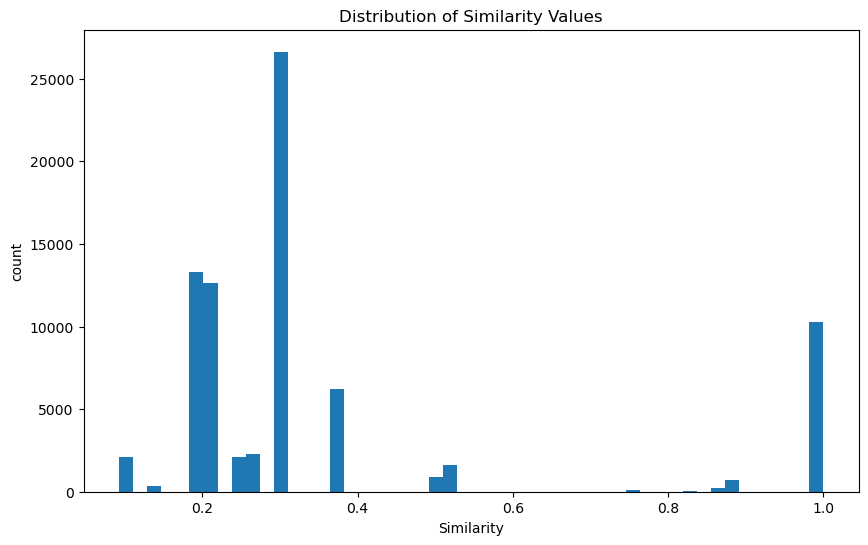

In [182]:
# Use the optimal weights to calculate the similarity matrix
optimal_weights = best_weights  
ecological_similarity_matrix, species_names = calculate_similarity_matrix(encoded_data, optimal_weights)

#distribution of similarity matrix
plot_similarity_distribution(ecological_similarity_matrix)

In [194]:
# Ensure that G_knn is the actual graph object
G_knn, modularity = create_knn_and_compute_modularity(similarity_matrix, species_names, df_data, k=5)



Network Statistics:
Number of nodes: 399
Number of edges: 1743
Average degree: 8.74
Network density: 0.0220


In [5]:
def visualize_and_save_knn_network(G_knn, output_filename="ecological_network.gml"):
    """
    Visualizes the KNN network and saves it as a GML file.
    
    Parameters:
        G_knn (networkx.Graph): The KNN graph to visualize.
        output_filename (str): The name of the output GML file.
    """
    # Set up the figure
    plt.figure(figsize=(12, 10))

    # Choose a layout for better visualization
    pos = nx.spring_layout(G_knn, seed=42)  # Use default spring layout without zoom effect

    # Draw the network
    nx.draw(G_knn, pos, with_labels=False, node_size=70, node_color="skyblue", font_size=12, font_weight="bold", edge_color="gray")

    # Set the title
    plt.title("Ecological Network Visualization", fontsize=16)

    # Display the plot
    plt.show()

    # Save the network to a GML file
    nx.write_gml(G_knn, output_filename)

    print(f"Network saved as {output_filename}")

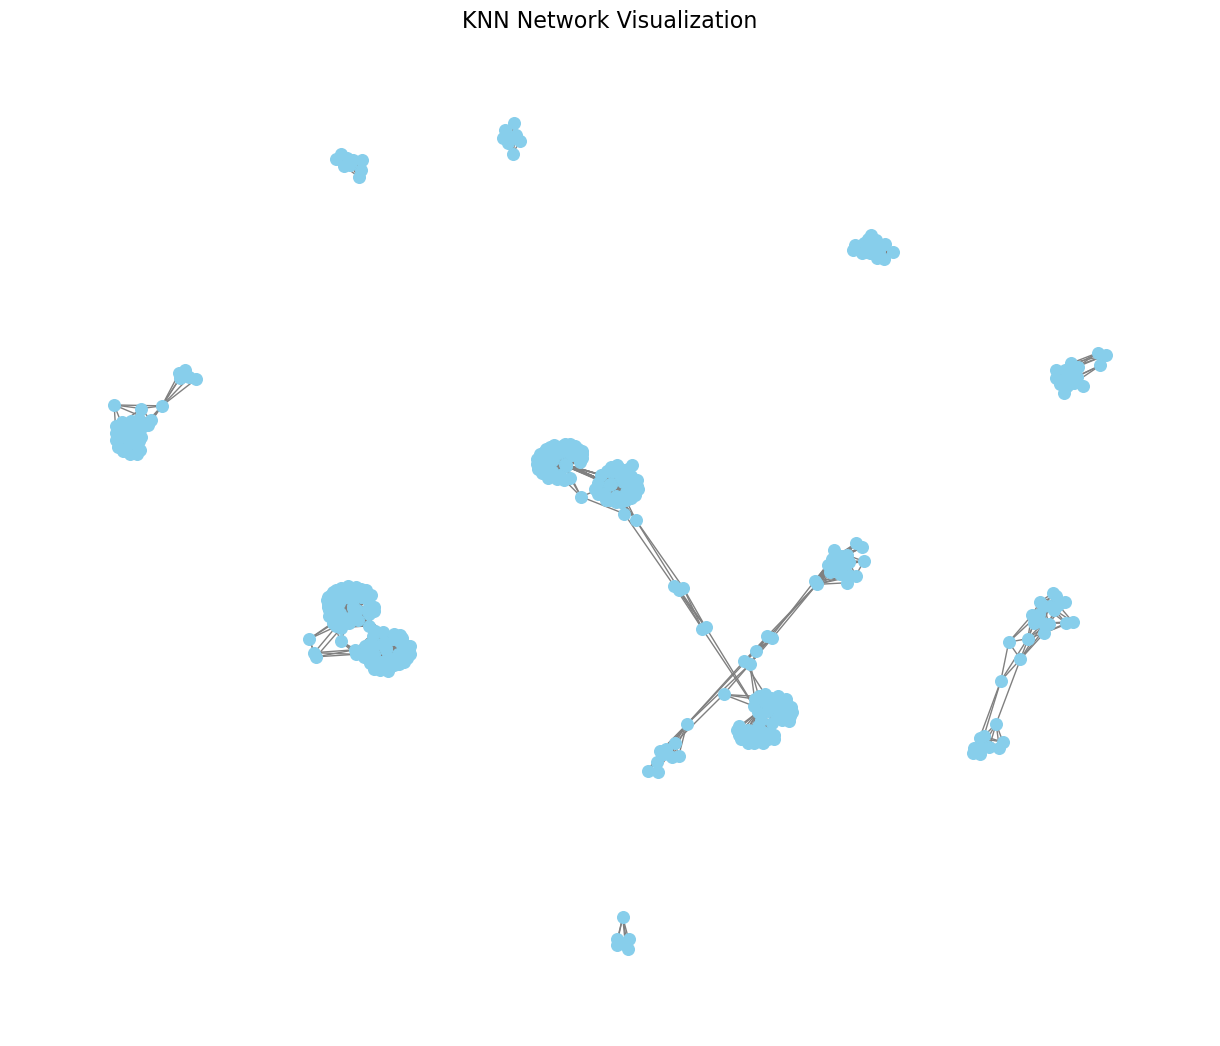

Network saved as ecological_network.gml


In [7]:
visualize_and_save_knn_network(G_knn, output_filename="ecological_network.gml")

In [200]:
def detect_communities(G):
    """
    Detect communities in a network using Louvain modularity maximization.

    Parameters:
        G: NetworkX Graph object.

    Returns:
        Dictionary mapping nodes to their community ID.
    """
    communities = modularity_max.greedy_modularity_communities(G)
    community_mapping = {}
    for community_id, community_nodes in enumerate(communities):
        for node in community_nodes:
            community_mapping[node] = community_id
    return community_mapping


In [201]:
community_mapping = detect_communities(G_knn)

In [189]:
def analyze_community(G, community_dict, community_id):
    # Get nodes in the community
    community_nodes = [node for node, comm_id in community_dict.items() if comm_id == community_id]
    
    # Create subgraph for the community
    subgraph = G.subgraph(community_nodes)
    
    # Check for disconnected components
    components = list(nx.connected_components(subgraph))
    largest_component = max(components, key=len)  # Get the largest connected component
    subgraph = subgraph.subgraph(largest_component)  # Focus on the largest component
    
    # Calculate centrality measures
    degree_centrality = nx.degree_centrality(subgraph)
    closeness_centrality = nx.closeness_centrality(subgraph)
    betweenness_centrality = nx.betweenness_centrality(subgraph)
    
    # Handle eigenvector centrality with try-except to catch convergence issues
    try:
        eigenvector_centrality = nx.eigenvector_centrality(subgraph)
    except nx.PowerIterationFailedConvergence:
        print(f"Eigenvector centrality calculation failed for community {community_id}")
        eigenvector_centrality = {}  # Assign empty dictionary if failed
    
    # Calculate additional metrics
    clustering_coefficient = nx.clustering(subgraph)
    avg_path_length = nx.average_shortest_path_length(subgraph) if nx.is_connected(subgraph) else float('inf')
    
    # Print out the results
    print(f"Community {community_id} Analysis:")
    print("Degree Centrality:", degree_centrality)
    print("Closeness Centrality:", closeness_centrality)
    print("Betweenness Centrality:", betweenness_centrality)
    print("Eigenvector Centrality:", eigenvector_centrality)
    print("Clustering Coefficient:", clustering_coefficient)
    print(f"Average Path Length: {avg_path_length}")
    print("="*50)
    
    return {
        'degree_centrality': degree_centrality,
        'closeness_centrality': closeness_centrality,
        'betweenness_centrality': betweenness_centrality,
        'eigenvector_centrality': eigenvector_centrality,
        'clustering_coefficient': clustering_coefficient,
        'avg_path_length': avg_path_length
    }


In [204]:
def visualize_communities_and_analysis(G, community_mapping):
    """
    Visualize each community in the network along with its summarized analysis results displayed as a text box.

    Parameters:
        G: NetworkX graph
        community_mapping: Dictionary mapping nodes to their community IDs
    """
    # Extract unique communities
    communities = list(set(community_mapping.values()))
    num_communities = len(communities)
    
    # Set up the subplots: Adjust figsize for the number of communities
    fig, axes = plt.subplots(nrows=num_communities, ncols=1, figsize=(10, 5 * num_communities))

    # Ensure axes is always a list for consistent indexing
    if num_communities == 1:
        axes = [axes]
    
    # Loop through communities
    for idx, community in enumerate(communities):
        community_nodes = [node for node, comm in community_mapping.items() if comm == community]
        subgraph = G.subgraph(community_nodes)

        # Analysis function: Replace with your actual analysis or use this sample
        degree_centrality = nx.degree_centrality(subgraph)
        closeness_centrality = nx.closeness_centrality(subgraph)
        betweenness_centrality = nx.betweenness_centrality(subgraph)
        clustering_coefficient = nx.clustering(subgraph)

        avg_path_length = (
            nx.average_shortest_path_length(subgraph)
            if nx.is_connected(subgraph)
            else float('inf')
        )

        # Compute summaries for each metric
        def summarize_metric(metric):
            return {
                "mean": np.mean(list(metric.values())),
                "max": np.max(list(metric.values())),
                "min": np.min(list(metric.values())),
            }

        degree_summary = summarize_metric(degree_centrality)
        closeness_summary = summarize_metric(closeness_centrality)
        betweenness_summary = summarize_metric(betweenness_centrality)
        clustering_summary = summarize_metric(clustering_coefficient)

        # Plot the subgraph
        ax = axes[idx]
        pos = nx.spring_layout(subgraph)  # Change layout as needed
        nx.draw(
            subgraph, pos, ax=ax, with_labels=False, node_size=50, font_size=8,
            node_color='skyblue', edge_color='gray'
        )
        ax.set_title(f"Community {community} Visualization", fontsize=14)

        # Format analysis results into a readable string
        analysis_str = (
            f"Community {community} Analysis:\n"
            f"Degree Centrality (Mean/Max/Min): {degree_summary['mean']:.2f}/{degree_summary['max']:.2f}/{degree_summary['min']:.2f}\n"
            f"Closeness Centrality (Mean/Max/Min): {closeness_summary['mean']:.2f}/{closeness_summary['max']:.2f}/{closeness_summary['min']:.2f}\n"
            f"Betweenness Centrality (Mean/Max/Min): {betweenness_summary['mean']:.2f}/{betweenness_summary['max']:.2f}/{betweenness_summary['min']:.2f}\n"
            f"Clustering Coefficient (Mean/Max/Min): {clustering_summary['mean']:.2f}/{clustering_summary['max']:.2f}/{clustering_summary['min']:.2f}\n"
            f"Average Path Length: {avg_path_length:.2f}\n"
        )
        
        # Add the analysis text box to the plot
        ax.text(
            0.05, 0.95, analysis_str, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='left',
            bbox=dict(facecolor='white', alpha=0.7)
        )

    # Adjust layout
    plt.tight_layout()
    plt.show()


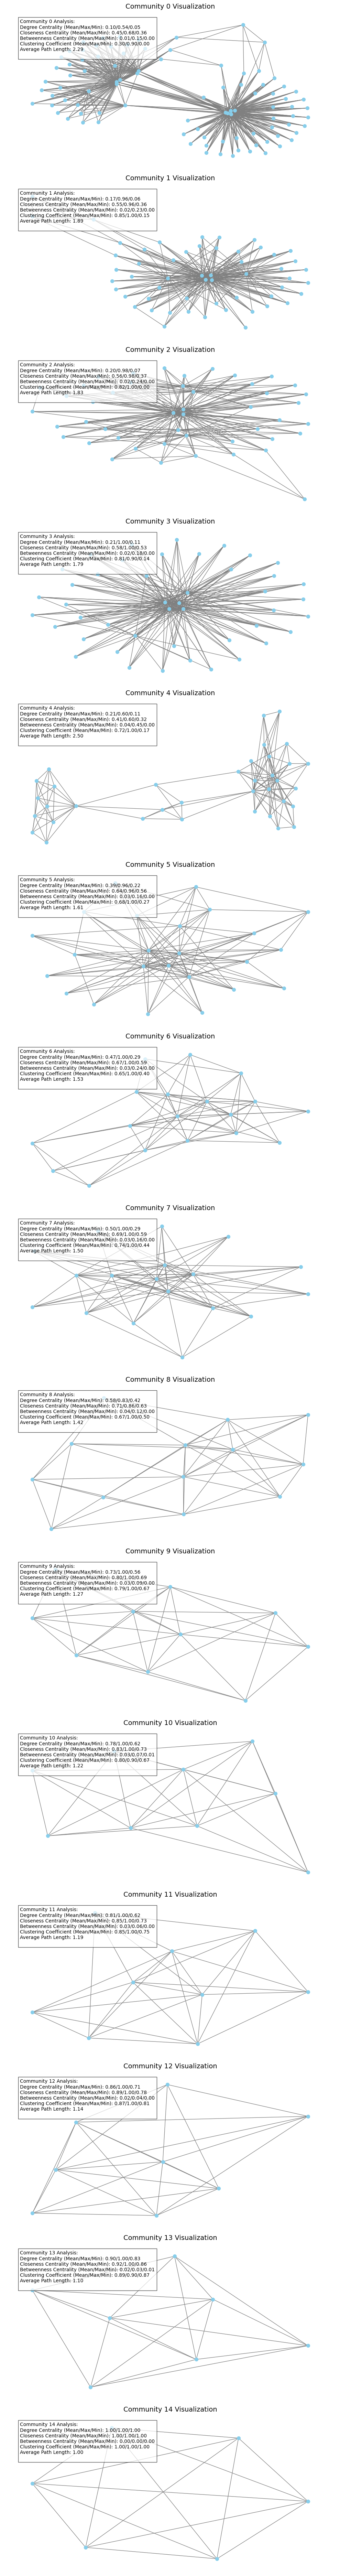

In [205]:
visualize_communities_and_analysis(G_knn, community_mapping)

In [191]:
def plot_network_on_map(G, community_dict, title="Ecological Network on Geographical Map"):
    """
    Plot an ecological network on a geographical map with nodes colored by community.
    
    Parameters:
        G: NetworkX graph with nodes containing latitude and longitude attributes
        community_dict: Dictionary with nodes as keys and community IDs as values
        title: Title of the map
    """
    # Create a Cartopy map using PlateCarree projection (lat-lon)
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([-180, 180, -60, 90])  # Longitude and latitude bounds
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.COASTLINE, edgecolor='black')
    ax.add_feature(cfeature.BORDERS, edgecolor='black')
    ax.set_title(title, fontsize=16)

    # Assign random colors to communities
    community_colors = {community: (random.random(), random.random(), random.random())
                        for community in set(community_dict.values())}

    # Plot nodes
    for node in G.nodes:
        # Get latitude and longitude from node attributes
        lat = G.nodes[node]['latitude']
        lon = G.nodes[node]['longitude']
        community = community_dict[node]

        # Plot the node on the map
        ax.scatter(lon, lat, s=50, c=[community_colors[community]], edgecolor='black', zorder=5,
                   transform=ccrs.PlateCarree())

    # Plot edges
    for u, v in G.edges:
        # Get latitudes and longitudes of the nodes
        lat_u, lon_u = G.nodes[u]['latitude'], G.nodes[u]['longitude']
        lat_v, lon_v = G.nodes[v]['latitude'], G.nodes[v]['longitude']

        # Plot the edge as a line
        ax.plot([lon_u, lon_v], [lat_u, lat_v], color='gray', alpha=0.5, linewidth=0.5, zorder=4,
                transform=ccrs.PlateCarree())

    legend_labels = [f"Community {community}" for community in community_colors]
    legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10)
                      for color in community_colors.values()]
    
    ax.legend(handles=legend_handles, labels=legend_labels, loc='upper left', title="Community Legend")


    # Show plot
    plt.show()


d:\App\python\Lib\site-packages\pyproj\transformer.py:817: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
d:\App\python\Lib\site-packages\pyproj\transformer.py:817: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
d:\App\python\Lib\site-packages\pyproj\transformer.py:817: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
d:\App\python\Lib\site-packages\pyproj\transformer.py:817: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
d:\App\python\Lib\site-packages\pyproj\transformer.py:817: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
d:\App\python\Lib\site-packages\pyproj\transformer.py:817: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
d:\App\python\Lib\site-packa

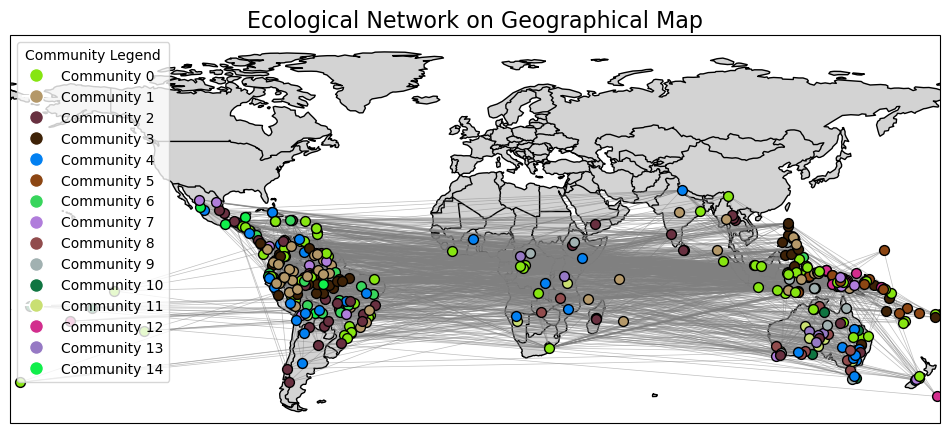

In [207]:
from matplotlib.lines import Line2D

plot_network_on_map(G_knn, community_mapping, title="Ecological Network on Geographical Map")

In [213]:

def gml_to_json_custom(gml_path, json_path):
    """
    Convert GML to custom JSON format with separate node and edge lists.

    Parameters:
        gml_path (str): Path to the input GML file.
        json_path (str): Path to save the output JSON file.

    Returns:
        dict: Custom JSON representation of the graph.
    """
    # Read the GML file
    G = nx.read_gml(gml_path)

    # Create custom format
    graph_data = {
        'nodes': [],
        'edges': []
    }

    # Add nodes with attributes
    for node, attrs in G.nodes(data=True):
        node_data = {'id': node}
        node_data.update(attrs)  # Include all node attributes
        graph_data['nodes'].append(node_data)

    # Add edges with attributes
    for source, target, attrs in G.edges(data=True):
        edge_data = {
            'source': source,
            'target': target
        }
        edge_data.update(attrs)  # Include all edge attributes
        graph_data['edges'].append(edge_data)

    # Save to JSON file
    with open(json_path, 'w') as f:
        json.dump(graph_data, f, indent=2)

    # Print summary
    print(f"Graph converted to JSON: {json_path}")
    print(f"Number of Nodes: {len(graph_data['nodes'])}")
    print(f"Number of Edges: {len(graph_data['edges'])}")

    return graph_data


In [214]:
gml_path = "ecological_network.gml"  # Path to the GML file created earlier
json_path = "knn_network.json"  # Desired path for the output JSON file

graph_data = gml_to_json_custom(gml_path, json_path)

Graph converted to JSON: knn_network.json
Number of Nodes: 399
Number of Edges: 1743
